In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az
import datetime

import IPython

from meridian import constants
from meridian.data import load
from meridian.data import test_utils
from meridian.model import model
from meridian.model import spec
from meridian.model import prior_distribution
from meridian.analysis import optimizer
from meridian.analysis import analyzer
from meridian.analysis import visualizer
from meridian.analysis import summarizer
from meridian.analysis import formatter

# check if GPU is available
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Your runtime has 25.8 gigabytes of available RAM

Num GPUs Available:  0
Num CPUs Available:  1


# Custom Functions

In [3]:
def create_channel_mappings(media, impressions):
    """
    Generate mapping dictionaries for media spend and impressions columns.

    Parameters:
        media (list of str): List of column names with spend/cost data.
                             Expected to have columns ending with '_cost'.
        impressions (list of str): List of column names with impressions data.
                                   Expected to have columns ending with '_cost_impressions'.

    Returns:
        tuple: Two dictionaries:
            - correct_media_spend_to_channel: Mapping of cost column names to simplified channel names.
            - correct_media_to_channel: Mapping of impressions column names to simplified channel names.
    """
    correct_media_spend_to_channel = {}
    for col in media:
        if col.endswith("_cost"):
            channel_name = col[:-len("_cost")]
        else:
            channel_name = col
        correct_media_spend_to_channel[col] = channel_name

    correct_media_to_channel = {}
    for col in impressions:
        if col.endswith("_impressions"):
          #substitute
            channel_name = col[:-len("_impressions")]
        else:
            channel_name = col
        correct_media_to_channel[col] = channel_name

    return correct_media_spend_to_channel, correct_media_to_channel

# Raw Data

In [38]:
# Assuming your CSV file is in the 'MyDrive' folder
#file_path = '/content/drive/MyDrive/mmm_train_all.csv'
file_path = 'mmm_train_all_phase2.csv'
# Read the CSV file into a pandas DataFrame
raw_data = pd.read_csv(file_path)

print(raw_data.shape)
raw_data = raw_data.drop_duplicates()
print(raw_data.shape)

(335, 45)
(335, 45)


In [39]:
folder_path = "data/usaonlyanalysis"
event_dates = pd.read_csv(folder_path + '/' + 'event_list.csv')
event_dates['find_date'] = event_dates['name'].apply(lambda x: x.find('20'))
event_dates=event_dates[event_dates['find_date']>0]
event_dates['datestr']=event_dates[['name','find_date']].apply(lambda x: x['name'][x['find_date']:x['find_date']+10], axis=1)
event_dates['datestr'] = event_dates['datestr'].apply(lambda x: x.replace("-",""))
event_dates['datestr'] = event_dates['datestr'].apply(lambda x: x.replace(" ",""))
event_dates['datestr'] = event_dates['datestr'].apply(lambda x: x[:8])
event_dates['date'] = event_dates['datestr'].apply(lambda x: str(datetime.datetime.strptime(str(x), "%Y%m%d").date()))
event_dates['event_hosted'] = 1
event_dates = event_dates[['date', 'event_hosted']].groupby('date').sum().reset_index()

In [40]:
folder_path = "data/usaonlyanalysis"
webinar_pt2 = pd.read_csv(folder_path + '/' + 'webinar_part2.csv')
webinar = pd.read_csv(folder_path + '/' + 'webinar_dates.csv')
webinar = pd.concat([webinar,webinar_pt2])

webinar['find_date'] = webinar['name'].apply(lambda x: x.find('20'))
webinar=webinar[webinar['find_date']>0]
webinar['datestr']=webinar[['name','find_date']].apply(lambda x: x['name'][x['find_date']:x['find_date']+8], axis=1)
webinar = webinar[webinar['datestr']!='2024 web']
webinar['date'] = webinar['datestr'].apply(lambda x: str(datetime.datetime.strptime(str(x), "%Y%m%d").date()))
webinar['webinar_occured'] = 1
webinar = webinar[['date', 'webinar_occured']].groupby('date').sum().reset_index()


In [ ]:
dates_exclude = raw_data[raw_data['event_spend']>0]
dates_exclude = dates_exclude['date'].to_list()
event_dates = event_dates[event_dates['date'].isin(dates_exclude)==False]
raw_data = pd.merge(raw_data, event_dates[['date', 'event_hosted']], on='date', how='left')
raw_data['event_hosted'] = raw_data['event_hosted'].fillna(0)
print(raw_data.shape[0])

raw_data = pd.merge(raw_data, webinar[['date', 'webinar_occured']], on='date', how='left')
raw_data['webinar_occured'] = raw_data['webinar_occured'].fillna(0)
print(raw_data.shape[0])

335


In [45]:
# Assuming your DataFrame has a date column called 'date'
df = raw_data.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Find gaps larger than 1 day
df['date_diff'] = df['date'].diff().dt.days
non_sequential = df[df['date_diff'] > 1]
print(non_sequential)

Empty DataFrame
Columns: [Unnamed: 0, model_week, date, iso_week, iso_year, ga4_sessions, refined_ga4_ressions, podcast_streams, linkedin_spend, linkedin_impressions, linkedin_clicks, gSearch_sessions, gSearch_impressions, gift_spend, email_opened_cnt, direct_spend, direct_spend_pharios, direct_spend_dc360, fb_spend, fb_impressions, fb_clicks, googleAds_spend, googleAds_impressions, event_spend, all_mql_count, linkedin_mql_count, sales_sourced_mql_cnt, pharios_mql_cnt, dc360_mql_count, dc360_mql_count.1, impactDotCom_ga4_sessions, sum_content_download, sum_blog_subscribers, sum_newsletter_signup, month, daily_avg_queries, inflation_rate, date_y, durable_goods_rates, all_less_linkedin_mql, averageMQL_linkedin, smoothed_MQL_linkedin, smoothed_linkedin_MQL_all, averageMQL, smoothed_MQL, event_hosted, webinar_occured, date_diff]
Index: []

[0 rows x 48 columns]


# Model Specs

In [6]:
models_dict = {}

In [7]:
model_name = 'baseline'
df_vars = ['date', 'podcast_streams', 'linkedin_spend', 'gSearch_sessions', 'gift_spend', 'email_opened_cnt', 
           'direct_spend','fb_spend','googleAds_spend','event_spend','impactDotCom_ga4_sessions', 'smoothed_MQL']
organic_vars =  ['podcast_streams', 'email_opened_cnt', 'impactDotCom_ga4_sessions']
control_vars = ['gSearch_sessions']
  
roi_m_vars = {'linkedin_spend': (0.30, 0.3),
  'gift_spend': (0.01, 0.4),
  'direct_spend': (0.01, 0.4),
  'fb_spend' : (0.10, 0.3),
  'googleAds_spend': (0.10, 0.25),
  'event_spend' :(0.01, 0.1)}
knots = 3
max_lag = 6
sample_size_prior = 500

baseline = {'response_var': "smoothed_MQL", 'df_variables':df_vars, 'organic_variables' : organic_vars, 'control_variables': control_vars, 'roi_m_vars':roi_m_vars, 'knots':knots, 'max_lag': max_lag, 'sample_size_prior':sample_size_prior}  

models_dict[model_name]=baseline

In [126]:
models_dict

{'baseline': {'response_var': 'smoothed_MQL',
  'df_variables': ['date',
   'podcast_streams',
   'linkedin_spend',
   'gSearch_sessions',
   'gift_spend',
   'email_opened_cnt',
   'direct_spend',
   'fb_spend',
   'googleAds_spend',
   'event_spend',
   'impactDotCom_ga4_sessions',
   'smoothed_MQL'],
  'organic_variables': ['podcast_streams',
   'email_opened_cnt',
   'impactDotCom_ga4_sessions'],
  'control_variables': ['gSearch_sessions'],
  'roi_m_vars': {'linkedin_spend': (0.3, 0.3),
   'gift_spend': (0.01, 0.4),
   'direct_spend': (0.01, 0.4),
   'fb_spend': (0.1, 0.3),
   'googleAds_spend': (0.1, 0.25),
   'event_spend': (0.01, 0.1)},
  'knots': 3,
  'max_lag': 6}}

In [161]:
output_dict = {}

# Model #1

## Specs

In [ ]:
model_iter = 'baseline'
response_var = models_dict[model_iter]['response_var']
all_vars = models_dict[model_iter]['df_variables']
organic = models_dict[model_iter]['organic_variables']
control = models_dict[model_iter]['control_variables']
roi_m = models_dict[model_iter]['roi_m_vars']
knots = models_dict[model_iter]['knots']
max_lag =  models_dict[model_iter]['max_lag']
sample_size_prior =  models_dict[model_iter]['sample_size_prior']
models_dict[model_iter]

model_1_data = raw_data[all]
model_1_data['revenue_var'] = model_1_data[pred]* 1000
data = model_1_data.copy()

{'response_var': 'smoothed_MQL',
 'df_variables': ['date',
  'podcast_streams',
  'linkedin_spend',
  'gSearch_sessions',
  'gift_spend',
  'email_opened_cnt',
  'direct_spend',
  'fb_spend',
  'googleAds_spend',
  'event_spend',
  'impactDotCom_ga4_sessions',
  'smoothed_MQL'],
 'organic_variables': ['podcast_streams',
  'email_opened_cnt',
  'impactDotCom_ga4_sessions'],
 'control_variables': ['gSearch_sessions'],
 'roi_m_vars': {'linkedin_spend': (0.3, 0.3),
  'gift_spend': (0.01, 0.4),
  'direct_spend': (0.01, 0.4),
  'fb_spend': (0.1, 0.3),
  'googleAds_spend': (0.1, 0.25),
  'event_spend': (0.01, 0.1)},
 'knots': 3,
 'max_lag': 6,
 'sample_size_prior': 500}

##  Model Setup

In [137]:
# STEP 2: LOAD AND PREPARE YOUR DATA
media = [
    col for col in data.columns
    if any(keyword in col.lower() for keyword in ['spend', 'cost', 'budget'])
]

# Exclude media channels with zero total spend
media = [col for col in media if data[col].sum() > 0]

# Example: define any organic or additional columns you may want to handle
organic = organic

# Print and verify selected media channels
print("Selected Media Channels:", media)

# # Convert date column to datetime
# data['date_week'] = pd.to_datetime(data['date_week'])
data['date_week'] =  data['date']

# Identify the output (revenue) column(s)
output = [
    col for col in data.columns
    if 'revenue_var' in col.lower()
]


# Create a time index t
data['t'] = range(len(data))

# Separate features (X) and target (y)
X = data.drop(output, axis=1)
y = data[output[0]]  # if there is only one revenue column

# Inspect columns
data.head()

Selected Media Channels: ['linkedin_spend', 'gift_spend', 'direct_spend', 'fb_spend', 'googleAds_spend', 'event_spend']


,date,podcast_streams,linkedin_spend,gSearch_sessions,gift_spend,email_opened_cnt,direct_spend,fb_spend,googleAds_spend,event_spend,impactDotCom_ga4_sessions,smoothed_MQL,revenue_var,date_week,t
0,2024-04-11,332.0,11063.50,1324.0,0.00,0.0,0.0,2169.57,6448.16,0.0,4813.0,61.0,61000.0,2024-04-11,0
1,2024-04-12,227.0,10985.40,1127.0,498.86,0.0,0.0,2189.92,4544.18,0.0,4061.0,60.0,60000.0,2024-04-12,1
2,2024-04-13,186.0,8826.29,504.0,0.00,0.0,0.0,2140.88,1676.13,0.0,2350.0,21.0,21000.0,2024-04-13,2
3,2024-04-14,120.0,7257.84,519.0,0.00,0.0,0.0,2404.75,2054.01,0.0,2307.0,30.0,30000.0,2024-04-14,3
4,2024-04-15,182.0,10275.43,1133.0,339.42,0.0,0.0,2307.37,5510.42,0.0,5930.0,116.0,116000.0,2024-04-15,4


In [138]:
cost_mapping, impressions_mapping = create_channel_mappings(media, media)
print("Cost Mapping:", cost_mapping)
print("Impressions Mapping:", impressions_mapping)

Cost Mapping: {'linkedin_spend': 'linkedin_spend', 'gift_spend': 'gift_spend', 'direct_spend': 'direct_spend', 'fb_spend': 'fb_spend', 'googleAds_spend': 'googleAds_spend', 'event_spend': 'event_spend'}
Impressions Mapping: {'linkedin_spend': 'linkedin_spend', 'gift_spend': 'gift_spend', 'direct_spend': 'direct_spend', 'fb_spend': 'fb_spend', 'googleAds_spend': 'googleAds_spend', 'event_spend': 'event_spend'}


In [139]:
# Fix the mismatch in controls by renaming 'events' => 'events_events'
# (or whichever naming scheme you prefer if you actually want it to be 'events')

coord_to_columns = load.CoordToColumns(
    time='date',
    kpi='revenue_var',   # make sure this matches your KPI column in the DataFrame
    controls=control,  # corrected name
    media=media,
    media_spend=media,
    organic_media=organic,  # or whichever email column you truly nee
)

loader = load.DataFrameDataLoader(
    df=data,
    kpi_type= 'revenue',
    coord_to_columns=coord_to_columns,
    media_to_channel=cost_mapping,
    media_spend_to_channel=cost_mapping,
)
data_meridian = loader.load()

/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/data/load.py:1033: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df[geo_column_name] = self.df[geo_column_name].replace(
/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/data/load.py:206: UserWarning: The `population` argument is ignored in a nationally aggregated model. It will be reset to [1]
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/data/input_data.py:463: UserWarning: Revenue from the `kpi` data is used when `kpi_type`=`revenue`. `revenue_per_kpi` is ignored.
  warnings.warn(


In [140]:
build_media_channel_args = data_meridian.get_paid_media_channels_argument_builder()

# Assuming Channel1,...,Channel6 are all media channels.
roi_m = build_media_channel_args(
  linkedin_spend=roi_m['linkedin_spend'],
  gift_spend=roi_m['gift_spend'],
  direct_spend=roi_m['direct_spend'],
  fb_spend=roi_m['fb_spend'],
  googleAds_spend=roi_m['googleAds_spend'],
  event_spend=roi_m['event_spend'],
) # This creates a list of channel-ordered (mu, sigma) tuples.
roi_m_mu, roi_m_sigma = zip(*roi_m)

prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(
        roi_m_mu, roi_m_sigma, name=constants.ROI_M
    )
)
model_spec = spec.ModelSpec(prior=prior, knots=knots, max_lag=max_lag)
mmm = model.Meridian(input_data=data_meridian, model_spec=model_spec)

/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/model/model.py:66: UserWarning: In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.
  warnings.warn(


## Train model

In [141]:
mmm.sample_prior(sample_size_prior)
#It tells the function to generate 500 samples from the prior distribution.x



from tqdm.notebook import tqdm  # Import tqdm for Jupyter Notebook
import time


start_time = time.time()
# Remove progress_callback from the sample_posterior call
mmm.sample_posterior(
    n_chains=5,
    n_adapt=500,
    n_burnin=500,
    n_keep=1000,
    parallel_iterations=100,
    # progress_callback=update_progress  # Remove this line
)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Runtime: {elapsed_time:.4f} seconds")

/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/model/prior_distribution.py:912: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. tau_g_excl_baseline has been automatically set to Deterministic(0).
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/model/prior_distribution.py:912: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_m has been automatically set to Deterministic(0).
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/model/prior_distribution.py:912: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_rf has been automatically set to Deterministic(0).
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/si

Runtime: 108.4307 seconds


## ROI Plots

['linkedin_spend', 'gift_spend', 'direct_spend', 'fb_spend', 'googleAds_spend', 'event_spend']
[(0.3, 0.3), (0.01, 0.4), (0.01, 0.4), (0.1, 0.3), (0.1, 0.25), (0.01, 0.1)]


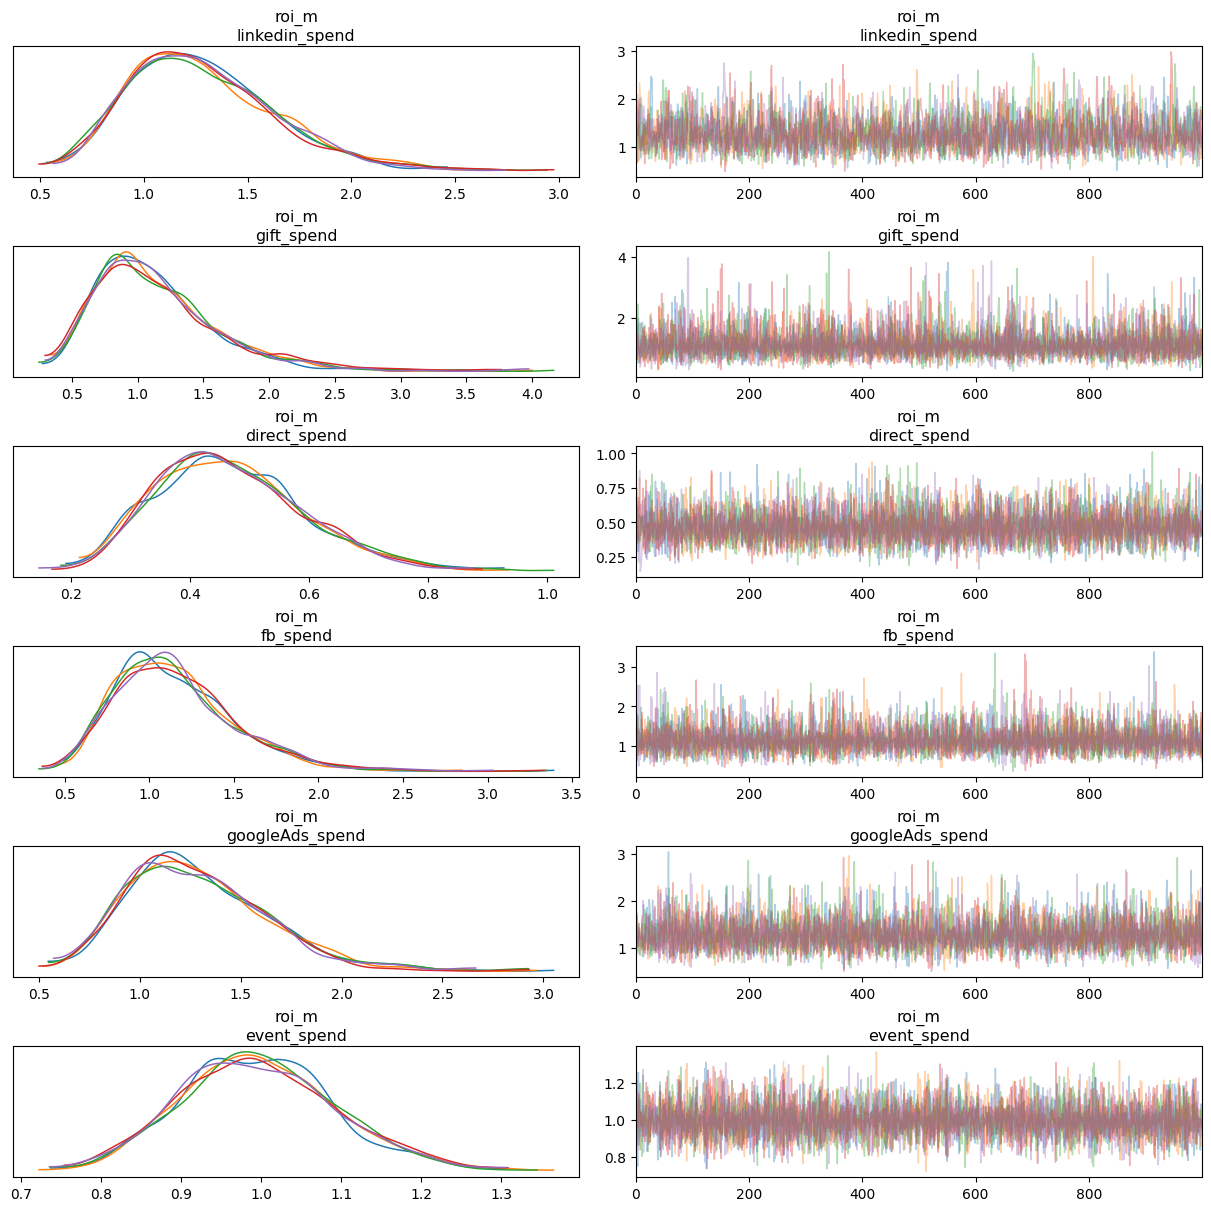

In [142]:
print(['linkedin_spend', 'gift_spend', 'direct_spend', 'fb_spend',
       'googleAds_spend', 'event_spend'])
print(roi_m)
parameters_to_plot=["roi_m"]
for params in parameters_to_plot:
  az.plot_trace(
      mmm.inference_data,
      var_names=params,
      compact=False,
      backend_kwargs={"constrained_layout": True},
  )

In [ ]:
output_dict[model_iter] = {'model_diagnostics': visualizer.ModelDiagnostics(mmm),
'model_summary':visualizer.MediaSummary(mmm),
'media_effects': visualizer.MediaEffects(mmm),
'model_fit' : visualizer.ModelFit(mmm)}



/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/analysis/analyzer.py:556: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


##  Model Fit Diagnostics

In [188]:
model_fit = output_dict[model_iter]['model_diagnostics']
model_fit.plot_rhat_boxplot()

alt.LayerChart(...)

In [189]:
model_fit = output_dict[model_iter]['model_fit']
model_fit.plot_model_fit()


alt.LayerChart(...)

In [190]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.predictive_accuracy_table()

/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/analysis/analyzer.py:556: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


,metric,geo_granularity,value
0,R_Squared,national,0.496235
1,MAPE,national,0.297679
2,wMAPE,national,0.273235


## Model Output

In [195]:
media_summary = output_dict[model_iter]['model_summary']
media_summary.summary_table()

/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/analysis/analyzer.py:855: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  warnings.warn(
/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py:371: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  return py_builtins.overload_of(f)(*args)
/Users/clairedanaher/.pyenv/versions/3.11.11/envs/meridian/lib/python3.11/site-packages/meridian/analysis/visualizer.py:1619: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .aggregate(lambda g: f'{g[0]} ({g[1]}, {g[2]})')


,channel,distribution,impressions,% impressions,spend,% spend,cpm,incremental outcome,% contribution,roi,effectiveness,mroi,cpik
0,linkedin_spend,prior,"3,841,929",51%,"$3,841,929",51%,"$1,000","$5,387,092 ($3,211,522, $8,397,894)","19.4% (11.5%, 30.2%)","1.4 (0.8, 2.2)","1.40 (0.84, 2.19)","0.7 (0.2, 1.2)","$0.7 ($0.5, $1.2)"
1,linkedin_spend,posterior,"3,841,929",51%,"$3,841,929",51%,"$1,000","$4,951,646 ($3,045,746, $7,480,791)","28.7% (17.7%, 43.4%)","1.3 (0.8, 1.9)","1.29 (0.79, 1.95)","0.5 (0.2, 0.9)","$0.8 ($0.5, $1.3)"
2,gift_spend,prior,"89,413",1%,"$89,413",1%,"$1,000","$96,870 ($48,940, $164,535)","0.3% (0.2%, 0.6%)","1.1 (0.5, 1.8)","1.08 (0.55, 1.84)","0.5 (0.2, 0.9)","$1.0 ($0.5, $1.8)"
3,gift_spend,posterior,"89,413",1%,"$89,413",1%,"$1,000","$102,808 ($48,885, $187,094)","0.6% (0.3%, 1.1%)","1.1 (0.5, 2.1)","1.15 (0.55, 2.09)","0.5 (0.2, 1.0)","$0.9 ($0.5, $1.8)"
4,direct_spend,prior,"1,061,271",14%,"$1,061,271",14%,"$1,000","$1,180,614 ($570,792, $2,219,291)","4.2% (2.1%, 8.0%)","1.1 (0.5, 2.1)","1.11 (0.54, 2.09)","0.6 (0.2, 1.1)","$1.0 ($0.5, $1.9)"
5,direct_spend,posterior,"1,061,271",14%,"$1,061,271",14%,"$1,000","$496,805 ($304,602, $734,337)","2.9% (1.8%, 4.3%)","0.5 (0.3, 0.7)","0.47 (0.29, 0.69)","0.2 (0.1, 0.3)","$2.2 ($1.4, $3.5)"
6,fb_spend,prior,"679,517",9%,"$679,517",9%,"$1,000","$801,056 ($477,865, $1,235,201)","2.9% (1.7%, 4.4%)","1.2 (0.7, 1.8)","1.18 (0.70, 1.82)","0.6 (0.2, 1.0)","$0.9 ($0.6, $1.4)"
7,fb_spend,posterior,"679,517",9%,"$679,517",9%,"$1,000","$784,399 ($455,679, $1,231,586)","4.5% (2.6%, 7.1%)","1.2 (0.7, 1.8)","1.15 (0.67, 1.81)","0.5 (0.2, 1.0)","$0.9 ($0.6, $1.5)"
8,googleAds_spend,prior,"1,568,982",21%,"$1,568,982",21%,"$1,000","$1,793,188 ($1,172,551, $2,597,992)","6.4% (4.2%, 9.3%)","1.1 (0.7, 1.7)","1.14 (0.75, 1.66)","0.6 (0.2, 1.0)","$0.9 ($0.6, $1.3)"
9,googleAds_spend,posterior,"1,568,982",21%,"$1,568,982",21%,"$1,000","$2,020,600 ($1,266,450, $2,998,262)","11.7% (7.3%, 17.4%)","1.3 (0.8, 1.9)","1.29 (0.81, 1.91)","0.7 (0.3, 1.1)","$0.8 ($0.5, $1.2)"


In [196]:
# Generate each individual chart and remove their individual config attributes to avoid conflicts on concatenation
media_summary.plot_contribution_waterfall_chart()

alt.LayerChart(...)

In [197]:
media_effects = output_dict[model_iter]['media_effects']
media_effects.plot_response_curves()

alt.FacetChart(...)

In [198]:
media_effects.plot_adstock_decay()


alt.FacetChart(...)